In [150]:
import pandas as pd
import os
from nltk.corpus import stopwords
import nltk.data
import logging
import time
import numpy as np  # Make sure that numpy is imported
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from KaggleWord2VecUtility import KaggleWord2VecUtility
import json
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [151]:
# whocalled has 171660 with comments among 555146 records
#scrapy_data = '/home/fujun/phone-data/whocalled.json'
# callercomplaints has 184245 unique phones with comments among 188130 records
data_root = '/home/fujunl/phone-scraping-data/'
phone_comments = {}
scrapy_data = data_root + 'callercomplaints.json'
with open(scrapy_data) as f:
    data = json.load(f)
    #data = data[:100]
    for record in data:
        phone = record['phone_id'].split('-')[0]
        
        comments = [comment['caller_report'] for comment in record['phone_comments']]
        if not comments:
            continue
            
        if phone not in phone_comments:
            phone_comments[phone] = comments
        else:
            phone_comments[phone].extend(comments)

print len(data), len(phone_comments)

In [152]:
num_comments = [len(comments) for comments in phone_comments.values()]
print max(num_comments), min(num_comments), np.median(num_comments), np.mean(num_comments)

In [64]:
tmp = phone_comments.values()[0]
print type(tmp[0])
print sys.getdefaultencoding()

In [67]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
comment_sentences = []  # Initialize an empty list of sentences
print "Parsing Comments"
for phone, comments in phone_comments.items():
    #print '******* ThiS PhoNE: {} has {} comments **********'.format(phone, len(comments))
    for comment in comments:
        if not comment:
            continue
        if comment:
            comment_sentences += KaggleWord2VecUtility.review_to_sentences(comment, tokenizer)

In [69]:
print len(comment_sentences)
print comment_sentences[0]

In [140]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)
model_name = "callercomplaints.wordvec"

# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 10   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print "Training Word2Vec model..."
model = Word2Vec(comment_sentences, workers=num_workers, size=num_features, \
                 min_count = min_word_count, window = context, sample = downsampling, seed=1)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)
# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()

model.save(model_name)

In [141]:
start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.syn0
num_clusters = word_vectors.shape[0] / 64

# Initalize a k-means object and use it to extract centroids
print "Running K means"
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )
# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print "Time taken for K Means clustering: ", elapsed, "seconds."
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( model.index2word, idx ))

In [90]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [147]:
# Pre-allocate an array for the training set bags of centroids (for speed)
phone_ids = phone_comments.keys()
phone_feats = np.zeros( (len(phone_ids), num_clusters), dtype="float32" )
for i, phone_id in enumerate(phone_ids):
    feat = np.zeros(num_clusters, dtype="float32")
    count = 0
    for comment in phone_comments[phone_id]:
        if not comment:
            continue
        count += 1
        clean_comment = KaggleWord2VecUtility.review_to_wordlist(comment,remove_stopwords=True )
        feat += create_bag_of_centroids(clean_comment, word_centroid_map)
    if count:
        feat = np.divide(feat, count)
    phone_feats[i] = feat

In [143]:
print phone_feats.shape

In [148]:
from sklearn.decomposition import PCA as sklearnPCA

#phone_feats = phone_feats[10:,:]
sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(phone_feats)


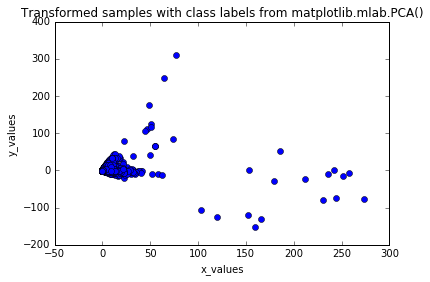

In [149]:
%pylab inline
from matplotlib import pyplot as plt
print sklearn_transf.shape
plt.plot(sklearn_transf[:,0],sklearn_transf[:,1], 'o')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

In [146]:
print sklearn_transf.shape
print sklearn_transf[0:20,:]
print phone_feats[0:20,0:20]

In [104]:
num_groups = 3
kmeans_clustering = KMeans(n_clusters = num_groups)
idx = kmeans_clustering.fit_predict(phone_feats)

In [106]:
print idx[:100]
f1,f2,f3 = open("type1.txt", 'w'),open("type2.txt", 'w'),open("type3.txt", 'w')
limit = 100
cnt = [0,0,0]
for gid in idx:
    if 
f1.close(),f2.close(),f3.close()

(None, None, None)

In [112]:
print list(idx).index(0)